# Training of the translation model.

Replicating the results of VectorBridge (https://github.com/P-H-B-D/EmbeddingsTranslation) is doing, except in pytorch and GPU-optimized. It is very advantageous to run this code on Google Colab or similar

In [ ]:
# If on google colab, uncomment these. 

# from google.colab import drive
# drive.mount('/content/drive')
# !pip install sentence-transformers

Mounted at /content/drive


#### Load the data from drive

Replace paths with your own google drive locations. All data generated from ```./altModels.ipynb```

In [ ]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

fns=['/content/drive/MyDrive/488_research/sbertDf.csv','/content/drive/MyDrive/488_research/mpnetDf.csv'] #Replace with your data locations
modelNames=['SBERT','MPNet']


sbert=pd.read_csv(fns[0])
sbert['content_vector'] = sbert['content_vector'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))

mpnet=pd.read_csv(fns[1])
mpnet['content_vector'] = mpnet['content_vector'].apply(lambda x: np.fromstring(x[1:-1], sep=' '))

sbert=sbert.rename(columns={"content_vector": "x (sbert)"})
mpnet=mpnet.rename(columns={"content_vector": "y (mpnet)"})
df=mpnet.join(sbert.set_index('text'), on='text')
print(len(df))
df.head()

10000


,text,y (mpnet),x (sbert)
0,Adobe Illustrator is a computer program for ma...,"[0.0086960867, -0.0653527156, -0.0293920096, 0...","[-0.0202746745, -0.0202211998, -0.019727584, 0..."
1,Andouille is a type of pork sausage. It is spi...,"[-0.00322549418, -0.00338032283, 0.0311240926,...","[0.0184027124, 0.0413582809, -0.0338581949, -0..."
2,"In mathematics, arithmetic is the basic study ...","[-0.0192546863, 0.0381052382, -0.00522099249, ...","[-0.03057622, 0.00578788, -0.03859627, -0.0394..."
3,"Aquaculture is the farming of fish, shrimp, ab...","[-0.0120306993, 0.0292836018, -0.0465631112, -...","[0.0260908678, -0.0373822898, 0.00790265296, -..."
4,An Abrahamic Religion is a religion whose foll...,"[-0.00904437155, 0.00528559415, -0.00215970585...","[0.042490527, 0.0978242308, -0.0435614213, 0.0..."


In [ ]:
print('x shape', df.head()['y (mpnet)'][0].shape)
print('y shape', df.head()['x (sbert)'][0].shape)


from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)
print('train shape', train.shape)
print('test shape', test.shape)

# Convert data to PyTorch tensors
train_x = torch.tensor(np.vstack(train['x (sbert)'].values), dtype=torch.float32)
train_y = torch.tensor(np.vstack(train['y (mpnet)'].values), dtype=torch.float32)
test_x = torch.tensor(np.vstack(test['x (sbert)'].values), dtype=torch.float32)
test_y = torch.tensor(np.vstack(test['y (mpnet)'].values), dtype=torch.float32)

# Create TensorDataset for training and validation
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

# Create DataLoader for training and validation
batch_size = 256  # You can adjust this batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(test_dataset, batch_size=batch_size)

x shape (768,)
y shape (384,)
train shape (8000, 3)
test shape (2000, 3)


# Model Definition

Epoch 1/100, Train Loss: 0.7329, Validation Loss: 0.6352
Epoch 2/100, Train Loss: 0.6497, Validation Loss: 0.5935
Epoch 3/100, Train Loss: 0.6007, Validation Loss: 0.5611
Epoch 4/100, Train Loss: 0.5412, Validation Loss: 0.5046
Epoch 5/100, Train Loss: 0.4844, Validation Loss: 0.4563
Epoch 6/100, Train Loss: 0.4400, Validation Loss: 0.4095
Epoch 7/100, Train Loss: 0.4038, Validation Loss: 0.3676
Epoch 8/100, Train Loss: 0.3734, Validation Loss: 0.3409
Epoch 9/100, Train Loss: 0.3466, Validation Loss: 0.3169
Epoch 10/100, Train Loss: 0.3229, Validation Loss: 0.2878
Epoch 11/100, Train Loss: 0.3024, Validation Loss: 0.2741
Epoch 12/100, Train Loss: 0.2834, Validation Loss: 0.2529
Epoch 13/100, Train Loss: 0.2663, Validation Loss: 0.2227
Epoch 14/100, Train Loss: 0.2506, Validation Loss: 0.2074
Epoch 15/100, Train Loss: 0.2366, Validation Loss: 0.2012
Epoch 16/100, Train Loss: 0.2242, Validation Loss: 0.1919
Epoch 17/100, Train Loss: 0.2126, Validation Loss: 0.1688
Epoch 18/100, Train Los

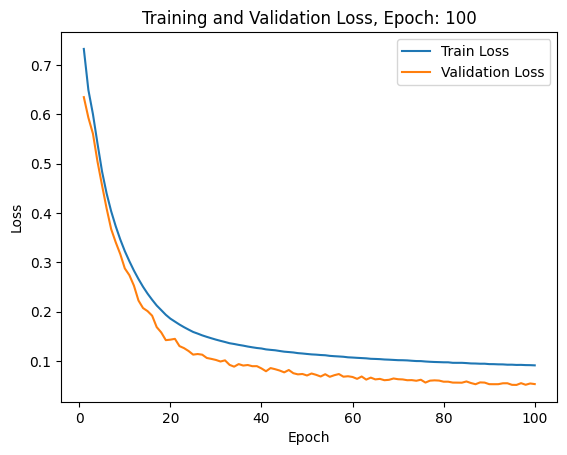

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLP(nn.Module):
    def __init__(self, weight_decay=0.00000, dropout_prob=0.1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=384, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=4096)
        self.fc3 = nn.Linear(in_features=4096, out_features=2048)
        self.fc4 = nn.Linear(in_features=2048, out_features=768)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.weight_decay = weight_decay

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

model = MLP().to(device)  # Move the model to the GPU if available
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=model.weight_decay)

def cosine_similarity_loss(outputs, targets):
    outputs = F.normalize(outputs, p=2, dim=-1)
    targets = F.normalize(targets, p=2, dim=-1)

    # Calculate the cosine similarity
    similarity = torch.sum(outputs * targets, dim=-1)

    loss = 1 - similarity
    return loss.mean()

# Training

In [ ]:
num_epochs = 100  # You can adjust this

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    total_train_loss = 0

    for batch in train_loader:
      inputs, targets = batch
      inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = cosine_similarity_loss(outputs, targets)
      total_train_loss += loss.item()

      loss.backward()
      optimizer.step()

    average_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # No need to track gradients during validation
        for batch in validation_loader:

            inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU

            outputs = model(inputs)
            loss = cosine_similarity_loss(outputs, targets)
            total_val_loss += loss.item()

    average_val_loss = total_val_loss / len(validation_loader)

    # Print statistics

    train_losses.append(average_train_loss)
    val_losses.append(average_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}")

plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss, Epoch: ' + str(epoch+1))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Example use case of model for embeddings translation:

- Input: Dim 384 vector from SBERT
- Output: Dim 768 vector from SBERT->MPNET trained translation model

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
import torch

model.eval()  # Eval mode, no need to track gradients

mpnet_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
sbert_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

encoding_target = ["The baseball player was red in the face."]

# Encode the text using Sentence Transformers models
mpnet_encoded_data = [mpnet_model.encode(x) for x in encoding_target]

sbert_encoded_data = [sbert_model.encode(x) for x in encoding_target]


input_vector=np.array(sbert_encoded_data[0]).astype(np.float32)
input_tensor = torch.tensor(input_vector).unsqueeze(0).to(device)
with torch.no_grad():
    pred = model(input_tensor).to(device)

actual=np.array(mpnet_encoded_data[0]).astype(np.float32)

similarity = np.dot(pred.to('cpu'), actual.T) / (np.linalg.norm(pred.to('cpu')) * np.linalg.norm(actual))
print("Cosine similarity: ", similarity)

Cosine similarity:  [0.4008888]
